# Learning Goals

By the end of this tutorial you will: <br>
* Learn to search a survey for observations of a known target.
* Be able to plot a color-magnitude diagram.
* Use coordinates to plot a spectrum of a known member in a dwarf galaxy. 

# Introduction

There are a number of dwarf galaxies that are gravitationally bound to the Milky Way. These satellites are small and generally faint companions in the Local Group that are not observable with the naked eye, except for the Large and Small Magenllanic Cloud. A vast majority of these satellites are known as Dwarf spheroidal galaxies [Metz et al. 2018](https://ui.adsabs.harvard.edu/abs/2007MNRAS.376..387M/abstract), and we will explote ways to analyze a dwarf spheroidal galaxy in this notebook.

We will be searching the [Pan-STARRS](https://outerspace.stsci.edu/display/PANSTARRS/) (PS1) catalog for data on an already discovered dwarf galaxy. The methods we use in this notebook can be extended to find new dwarf galaxies but in this application we will be using the MAST archive and its tools to search PS1 for data on an already known target. To choose our target, we will be referencing the paper "Milky Way Satellite Census. I. The Observational Selection Function for Milky Way Satellites in DES Y3 and Pan-STARRS DR1" by [Drlica-Wagner et al. 2020](https://iopscience.iop.org/article/10.3847/1538-4357/ab7eb9).

After searching PS1 for data on our target, we will use the data to plot a color-magnitude diagram of the galaxy and also plot an image of the field of view of our target. Next, we will choose another target, repeat the steps of gathering PS1 data, and compare both target's color-magnitude diagrams. Lastly, we will search Hubble Space Telescope data to plot a spectral image of our first target. 


# Imports

The following cell holds the imported packages. These packages are necessary for running the rest of the cells in this notebook. A description of each import is as follows:

* numpy to handle array functions
* Imvis and Specvis from Jdavis to show images and extract spectra
* fits from astropy.io for accessing FITS files
* Table from astropy.table for creating tidy tables of the data
* ascii from astropy.io for accessing the API results
* matplotlib.pyplot for plotting data
* Mast, Observations, and Catalogs from astroquery.mast for querying data and observations from the MAST archive
* requests for gathering data from the PS1 API
* units from astropy and SkyCoord from astropy.coordinates for converting RA and Dec into degrees

In [1]:
#pip install jdaviz --upgrade #this cell is necessary if you have not yet installed Jdavis

Note: you may need to restart the kernel to use updated packages.


In [4]:
%matplotlib inline
import numpy as np
import matplotlib.pyplot as plt
import matplotlib.colors as colors
import requests
from PIL import Image
from io import BytesIO
from jdaviz import Imviz, Specviz
from astropy.io import fits
import astropy.utils
from astropy.table import Table
from astroquery.mast import Mast, Observations, Catalogs
from astropy.io import ascii
from astropy import units as u
from astropy.coordinates import SkyCoord
from astropy.wcs import WCS

# Searching PS1 Data for a Known Target

## Choosing a Target

Using Table 2 and Table 4 from Drlica-Wagner et al. 2020, we can choose a galaxy that has PS1 data to search for. We will choose the galaxy with the brightest magnitude that has been confirmed using PS1: **Leo I**. 

Table 2 lists the Right Acension, Declination, and distance of **Leo I** which we will use to search the database. We can see that it's basic characteristics are: 
* Right Ascension: 152.1146 degrees
* Declination: 12.3059 degrees
* Distance: 254 kiloparsecs 
* M_v: −11.78 

### Gather necessary parameters 

Table 2 lists the Right Acension, Declination, and distance of **Leo I** which we will use to search the database. Additionally, we will need the API url in order to search PS1 for this target. We are using a search radius around **Leo I** of 12 arcminutes to be sure we are looking at the entire galaxy, [SIMBAD](https://simbad.u-strasbg.fr/simbad/sim-id?Ident=leo+I&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id) lists the angular size of **Leo I** as 11.5 arcminutes. 

In [5]:
ra = "152.1146" #[deg]
dec = "12.3059" #[deg]
dist = "254" #[kpc]
radius = "0.2" #[deg] = 12 arcminutes

baseurl="https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/" #this is the base url for querying the API
release = "dr1/" #you can also look at dr2 if you want
obj = "mean" #we will look at the mean photometric information for our target
condition = "nDetections.gte=1" #this condition allows us to only get data where at least 1 observation has been made
form = "csv"

## Retrieve PS1 data

The Panoramic Survey Telescope & Rapid Response System (Pan-STARRS) is a wide-field imaging facility developed at the University of Hawaii's Institute for Astronomy. We are going to be using the MAST API for PS1 to gather our data. Discriptions for the PS1 MeanObjectView table fields can be found here: https://outerspace.stsci.edu/display/PANSTARRS/PS1+MeanObjectView+table+fields . 

### Build API URL and Get Data

In [6]:
#now build the url to get the data using the parameters we gathered
url = baseurl+release+obj+"?ra="+ra+"&dec="+dec+"&radius="+radius+"&"+condition+"&format="+form
print(url)

#Request data from the API
results = requests.get(url)
results = results.text

#Make a table from the results
tab = ascii.read(results)
tab[0:5]

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/mean?ra=152.1146&dec=12.3059&radius=0.2&nDetections.gte=1&format=csv


objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,tessID,projectionID,skyCellID,randomID,batchID,dvoRegionID,processingVersion,objInfoFlag,qualityFlag,raStack,decStack,raStackErr,decStackErr,raMean,decMean,raMeanErr,decMeanErr,epochMean,posMeanChisq,cx,cy,cz,lambda,beta,l,b,nStackObjectRows,nStackDetections,nDetections,ng,nr,ni,nz,ny,gQfPerfect,gMeanPSFMag,gMeanPSFMagErr,gMeanPSFMagStd,gMeanPSFMagNpt,gMeanPSFMagMin,gMeanPSFMagMax,gMeanKronMag,gMeanKronMagErr,gMeanKronMagStd,gMeanKronMagNpt,gMeanApMag,gMeanApMagErr,gMeanApMagStd,gMeanApMagNpt,gFlags,rQfPerfect,rMeanPSFMag,rMeanPSFMagErr,rMeanPSFMagStd,rMeanPSFMagNpt,rMeanPSFMagMin,rMeanPSFMagMax,rMeanKronMag,rMeanKronMagErr,rMeanKronMagStd,rMeanKronMagNpt,rMeanApMag,rMeanApMagErr,rMeanApMagStd,rMeanApMagNpt,rFlags,iQfPerfect,iMeanPSFMag,iMeanPSFMagErr,iMeanPSFMagStd,iMeanPSFMagNpt,iMeanPSFMagMin,iMeanPSFMagMax,iMeanKronMag,iMeanKronMagErr,iMeanKronMagStd,iMeanKronMagNpt,iMeanApMag,iMeanApMagErr,iMeanApMagStd,iMeanApMagNpt,iFlags,zQfPerfect,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagStd,zMeanPSFMagNpt,zMeanPSFMagMin,zMeanPSFMagMax,zMeanKronMag,zMeanKronMagErr,zMeanKronMagStd,zMeanKronMagNpt,zMeanApMag,zMeanApMagErr,zMeanApMagStd,zMeanApMagNpt,zFlags,yQfPerfect,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagStd,yMeanPSFMagNpt,yMeanPSFMagMin,yMeanPSFMagMax,yMeanKronMag,yMeanKronMagErr,yMeanKronMagStd,yMeanKronMagNpt,yMeanApMag,yMeanApMagErr,yMeanApMagStd,yMeanApMagNpt,yFlags,distance
str26,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64
PSO J100752.401+121011.081,-999,-999,-999,122601519683154148,1050851000012148,99982543695731,0,15576001168434,12260,1,1627,3,0.767531450621347,1050851,23279,3,310456320,37,-999.0,-999.0,-999.0,-999.0,151.96832746,12.16971828,0.07963000237941742,0.07963000237941742,57054.4228588,-999.0,-0.8628516865829539,0.45939838389699206,0.21080818730254194,149.64386869842306,0.6116471024815469,226.06819307608973,48.92032950474719,-999,0,1,0,0,1,0,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,0.9548550248146057,20.643800735473633,0.07820700109004974,-999.0,1,20.643800735473633,20.643800735473633,18.209400177001953,0.03454099968075752,-999.0,1,19.398799896240234,0.07820700109004974,-999.0,1,16777496,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,0.19743295941381817
PSO J100752.746+121015.726,-999,-999,-999,122601519697655733,1050851000012514,99982543696097,0,15576001169089,12260,1,1627,3,0.047600298232958,1050851,23279,3,268959744,32,-999.0,-999.0,-999.0,-999.0,151.96977817,12.17103513,0.2876400053501129,0.2876400053501129,55195.46811343,-999.0,-0.8628590411388408,0.4593742596274142,0.21083065412013818,149.64473272003607,0.6133490990989344,226.06744212752997,48.92217334652141,-999,0,1,0,0,0,0,1,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-999.0,-999.0,0,0,-999.0,-999.0,-999.0,-999.0,0,-999.0,-

## Plot Color-Magnitude Diagram (CMD) of Leo I

Color-Magnitude Diagrams (CMD) are a common way astronomers visualize the photometric parameters of a stellar system. Where the stars of a system fall on a CMD can tell you things like the age of that system and therefore, what types of stars it is composed of. The colors of a system can also tell us about the tempurature of that system. Color in astronomy is defined to be the difference between the magnitudes in one filter and the magnitudes in another filter.

### Gather arrays for plotting
A CMD consists of the magnitudes in one filter (y-axis) vs the difference between the magnitudes in that filter and the magnitudes in another filter (x-axis). For this example we will plot the magnitudes of **Leo I** in g vs the magnitude of **Leo I** in g-r. Additionally, we'll take a look at the CMD in r-i. What CMDs show is the relationship between the magnitudes of the signal we have detected in different color filters, so in this case a larger value for g (visual filter or bluer filter) minus r (red filter) means the star is redder, and a smaller g-r value means the star is bluer. A larger value in r (red) minus i (even more red) means the star is redder, and a smaller r-i value means the star is bluer. In order to plot these CMDs we will need a couple arrays:

* Magnitudes in the g filter
* Magnitudes in the r filter
* Magnitudes in the i filter


In [9]:
g_mag = tab["gMeanApMag"] #mean aperture magntiude in g filter
r_mag = tab["rMeanApMag"] #mean aperture magntiude in r filter
i_mag = tab["iMeanApMag"] #mean aperture magntiude in i filter

#convert to numpy arrays for easy plotting
g_mag = np.array(g_mag)
r_mag = np.array(r_mag)
i_mag = np.array(i_mag)

#get the difference between the filters 
g_r = np.subtract(g_mag,r_mag)

#get the difference between the filters 
r_i = np.subtract(r_mag,i_mag)

### Plot CMD in g - r

Text(0, 0.5, 'g')

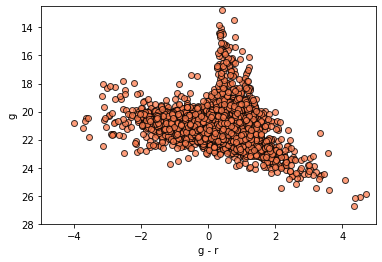

In [10]:
plt.scatter(g_r, g_mag, c = "coral", edgecolor = "black", alpha = 0.75)
plt.xlim(-5,5)
plt.ylim(28,12.5)
plt.xlabel("g - r")
plt.ylabel("g")

### Plot CMD in r - i

Text(0, 0.5, 'i')

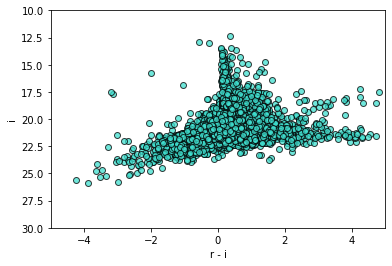

In [11]:
plt.scatter(r_i, i_mag, c = "turquoise", edgecolor = "black", alpha = 0.75)
plt.xlim(-5,5)
plt.ylim(30,10)
plt.xlabel("r - i")
plt.ylabel("i")

### Plot CMD in g-r and r-i side-by-side

Text(0, 0.5, 'i')

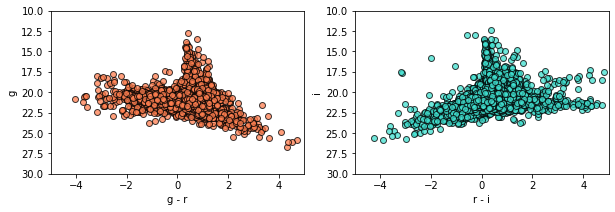

In [12]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,3)

ax1.scatter(g_r, g_mag, c = "coral", edgecolor = "black", alpha = 0.75)
ax1.set_xlim(-5,5)
ax1.set_ylim(30,10)
ax1.set_xlabel("g - r")
ax1.set_ylabel("g")

ax2.scatter(r_i, i_mag, c = "turquoise", edgecolor = "black", alpha = 0.75)
ax2.set_xlim(-5,5)
ax2.set_ylim(30,10)
ax2.set_xlabel("r - i")
ax2.set_ylabel("i")

## Plot Field of View (FOV) of Leo I

### Build the url to the fits file of the region for our target by the cutout service.


In [8]:
filters = "grizy"
size = "3000" #extracted image size in pixels (0.25 arcsec/pixel)
form = "fits" #file format of the file we would like

color = "red" #you can change this, red is typically the i or r filter

#get the url to the PS1 images
images_url = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra="+ra+"&dec="+dec+"&filters="+filters
#read the images data into a table
img_table = Table.read(images_url, format='ascii')

#get the first filename from the list of images
file = img_table['filename'][0]

#build the url to the fits file
fits_url = "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra="+ra+"&dec="+dec+"&size="+size+"&format="+form+"&"+color+"="+file

print(fits_url)

https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra=152.1146&dec=12.3059&size=3000&format=fits&red=/rings.v3.skycell/1627/003/rings.v3.skycell.1627.003.stk.g.unconv.fits


### Open the fits file and inspect the header

Here we will plot the field of view containing our galaxy, **Leo I**. In the next step we will also show you how to convert from pixel coordinates to sky coordinates (RA and Dec), to do this we will use the information in the FITS header combined with the astropy package WCS. FITS headers contain meta-deta about the image or data cube including but not limited to: the date, time, telescope, and instrument that made the observation, the exposure time and wavelength band of the data, and the physical size and binning of the pixels in the image.

In [9]:
#open the fits file and get the data
fh = fits.open(fits_url)
fits_img = fh[0].data

#get the FITS header
header = fh[0].header
wcs_leoI = WCS(header)

#take a look at the FITS header
header

SIMPLE  =                    T / file does conform to FITS standard             
BITPIX  =                  -32 / number of bits per data pixel                  
NAXIS   =                    2 / number of data axes                            
NAXIS1  =                 3000 / length of data axis 1                          
NAXIS2  =                 3000 / length of data axis 2                          
EXTEND  =                    T / FITS dataset may contain extensions            
COMMENT   FITS (Flexible Image Transport System) format is defined in 'Astronomy
COMMENT   and Astrophysics', volume 376, page 359; bibcode: 2001A&A...376..359H 
DATE    = '2022-09-22T19:32:56' / file creation date (YYYY-MM-DDThh:mm:ss UT)   
CTYPE1  = 'RA---TAN'                                                            
CTYPE2  = 'DEC--TAN'                                                            
CRVAL1  =     151.363632202094                                                  
CRVAL2  =     13.99999999999

### Plot the Field of View image

(400.0, 3000.0)

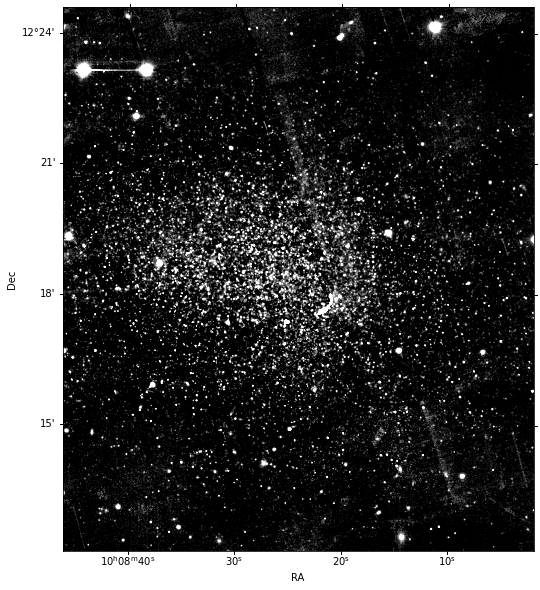

In [10]:
# replace NaN values with zero for display
fits_img[np.isnan(fits_img)] = 0.0

#make figure
fig = plt.figure(figsize = (10, 10))
#this subplot with the "projection" keyword will put our axes into units of RA and Dec
ax = plt.subplot(projection = wcs_leoI)
plt.imshow(fits_img, origin = 'lower', cmap = 'Greys_r', aspect = 'equal', vmin = 0, vmax = 255)
plt.xlabel('RA')
plt.ylabel('Dec')
plt.xlim(400,3000)

### Build the url to the color image file of the region for our target

In [11]:
size = "3000" #extracted image size in pixels (0.25 arcsec/pixel) = 12.5 arcminutes of angular size
form = "png" #file format of the file we would like, for color images it has to be a jpeg or png
filters = "yig"
red = "red"

#build the PS1 url for the color image
color_img_url = "https://ps1images.stsci.edu/cgi-bin/ps1filenames.py?ra="+ra+"&dec="+dec+"&filters="+filters
color_img_table = Table.read(color_img_url, format='ascii')
color_file = color_img_table['filename'][0]
color_png_url = "https://ps1images.stsci.edu/cgi-bin/fitscut.cgi?ra="+ra+"&dec="+dec+"&size="+size+"&format="+form

#now we need to get all three colors (r,g,b)
for i, param in enumerate(["red","green","blue"]):
            color_png_url = color_png_url + "&{}={}".format(param,color_img_table['filename'][i])


### Plot the FOV in Color

(400.0, 3000.0)

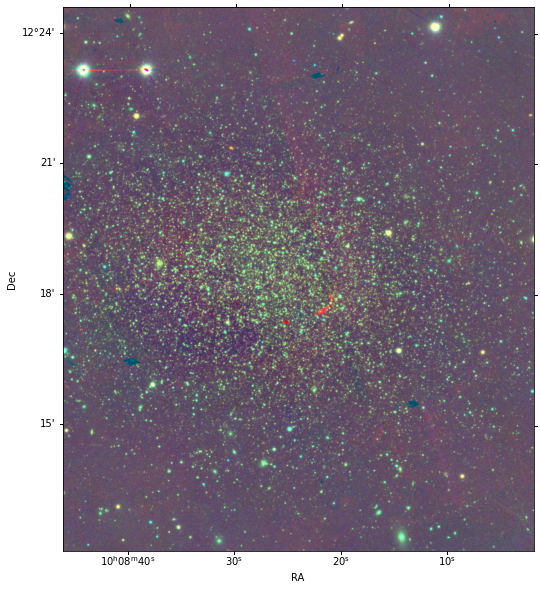

In [12]:
#open the url and get the image
r = requests.get(color_png_url)
im = Image.open(BytesIO(r.content))
#make figure
fig = plt.figure(figsize = (10, 10))
#this subplot with the "projection" keyword will put our axes into units of RA and Dec
ax = plt.subplot(projection = wcs_leoI)
#plot the image
plt.imshow(im, origin = 'lower', aspect = 'equal',vmin=0, vmax = 255) 
plt.xlabel(r'RA')
plt.ylabel(r'Dec')
plt.xlim(400,3000)

# Repeat with New Target and Compare

Now we will repeat the same process for a new target, **Draco II** and compare it with **Leo I**. 

## Retrieve PS1 data 
This is the same method as before, just using the position of **Draco II** instead. You can find the RA and Dec of **Draco II** in Table I of its discovery paper, [Laevens et al 2015](https://iopscience.iop.org/article/10.1088/0004-637X/813/1/44 ). It is also listed on [SIMBAD](https://simbad.u-strasbg.fr/simbad/sim-id?Ident=draco+ii&NbIdent=1&Radius=2&Radius.unit=arcmin&submit=submit+id). 

In [7]:
#read RA and Dec from either SIMBAD or Table 1 in Laevens et al 2015
r = '15:52:47.6'
d = '+64:33:55'
form = "csv"
radius = "0.1"

#Convert the RA and Dec to degrees
c = SkyCoord(r+d, unit=(u.hourangle, u.deg))
draco_ra = str(c.ra.degree)
draco_dec = str(c.dec.degree)

#now build the url to get the data from using the parameters we gathered
draco_url = baseurl+release+obj+"?ra="+draco_ra+"&dec="+draco_dec+"&radius="+radius+"&"+condition+"&format="+form
print(draco_url)

#Request data from the API
draco_results = requests.get(draco_url)
draco_results = draco_results.text

#Make a table from the results
draco_tab = ascii.read(draco_results)
draco_tab[0:5]

https://catalogs.mast.stsci.edu/api/v0.1/panstarrs/dr1/mean?ra=238.1983333333333&dec=64.56527777777778&radius=0.1&nDetections.gte=1&format=csv


objName,objAltName1,objAltName2,objAltName3,objID,uniquePspsOBid,ippObjID,surveyID,htmID,zoneID,tessID,projectionID,skyCellID,randomID,batchID,dvoRegionID,processingVersion,objInfoFlag,qualityFlag,raStack,decStack,raStackErr,decStackErr,raMean,decMean,raMeanErr,decMeanErr,epochMean,posMeanChisq,cx,cy,cz,lambda,beta,l,b,nStackObjectRows,nStackDetections,nDetections,ng,nr,ni,nz,ny,gQfPerfect,gMeanPSFMag,gMeanPSFMagErr,gMeanPSFMagStd,gMeanPSFMagNpt,gMeanPSFMagMin,gMeanPSFMagMax,gMeanKronMag,gMeanKronMagErr,gMeanKronMagStd,gMeanKronMagNpt,gMeanApMag,gMeanApMagErr,gMeanApMagStd,gMeanApMagNpt,gFlags,rQfPerfect,rMeanPSFMag,rMeanPSFMagErr,rMeanPSFMagStd,rMeanPSFMagNpt,rMeanPSFMagMin,rMeanPSFMagMax,rMeanKronMag,rMeanKronMagErr,rMeanKronMagStd,rMeanKronMagNpt,rMeanApMag,rMeanApMagErr,rMeanApMagStd,rMeanApMagNpt,rFlags,iQfPerfect,iMeanPSFMag,iMeanPSFMagErr,iMeanPSFMagStd,iMeanPSFMagNpt,iMeanPSFMagMin,iMeanPSFMagMax,iMeanKronMag,iMeanKronMagErr,iMeanKronMagStd,iMeanKronMagNpt,iMeanApMag,iMeanApMagErr,iMeanApMagStd,iMeanApMagNpt,iFlags,zQfPerfect,zMeanPSFMag,zMeanPSFMagErr,zMeanPSFMagStd,zMeanPSFMagNpt,zMeanPSFMagMin,zMeanPSFMagMax,zMeanKronMag,zMeanKronMagErr,zMeanKronMagStd,zMeanKronMagNpt,zMeanApMag,zMeanApMagErr,zMeanApMagStd,zMeanApMagNpt,zFlags,yQfPerfect,yMeanPSFMag,yMeanPSFMagErr,yMeanPSFMagStd,yMeanPSFMagNpt,yMeanPSFMagMin,yMeanPSFMagMax,yMeanKronMag,yMeanKronMagErr,yMeanKronMagStd,yMeanKronMagNpt,yMeanApMag,yMeanApMagErr,yMeanApMagStd,yMeanApMagNpt,yFlags,distance
str26,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,int64,float64,int64,int64,int64,int64,int64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,float64,int64,int64,int64,int64,int64,int64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64,float64,float64,float64,int64,float64,float64,float64,float64,float64,int64,float64,float64,float64,int64,int64,float64
PSO J155209.404+643743.423,-999,-999,-999,185552380391545210,965744000044967,330330229747624,0,14835660930045,18555,1,2525,17,0.317990677727378,965744,76911,3,503635968,60,238.0391857,64.62872875,0.0010000000474974513,0.0010000000474974513,238.03916746,64.62871358,0.00774999987334013,0.007860000245273113,56212.56826389,1.6902999877929688,-0.22681260986403146,-0.36352879768359103,0.9035501387645234,173.49038979300857,76.80391956396642,98.41605569202713,42.90683241087898,-999,5,57,10,11,16,9,11,0.999763011932373,16.674999237060547,0.003481999970972538,0.01193199958652258,8,16.659900665283203,16.695199966430664,16.742799758911133,0.0038739999290555716,0.01369599997997284,9,16.6830997467041,0.003959000110626221,0.012678000144660473,9,115000,0.9995629787445068,16.26650047302246,0.004021000117063522,0.014050000347197056,11,16.246700286865234,16.286300659179688,16.326000213623047,0.003444999922066927,0.0129399998113513,11,16.263999938964844,0.001851000008173287,0.006603999994695187,11,115000,0.9998000264167786,16.119400024414062,0.0026950000319629908,0.008630000054836273,11,16.105600357055664,16.13159942626953,16.167699813842773,0.006045999936759472,0.013775999657809734,14,16.10110092163086,0.003998999949544668,0.01271899975836277,14,115000,0.9991459846496582,16.06679916381836,0.004478000104427338,0.013356000185012817,5,16.04509925842285,16.08180046081543,16.123199462890625,0.004118000157177448,0.013855000026524067,6,16.060100555419922,0.002570000011473894,0.007395999971777201,6,115000,0.9985020160675049,16.036699295043945,0.012910000048577785,0.0291920006275177,10,16.011999130249023,16

## Plot CMDs of Draco II

Gather the arrays for plotting the color-magnitude diagrams using the same method as before. 

In [19]:
draco_g_mag = draco_tab["gMeanApMag"] #mean aperture magntiude in g filter
draco_r_mag = draco_tab["rMeanApMag"] #mean aperture magntiude in r filter
draco_i_mag = draco_tab["iMeanApMag"] #mean aperture magntiude in i filter

#convert to numpy arrays for easy plotting
draco_g_mag = np.array(draco_g_mag)
draco_r_mag = np.array(draco_r_mag)
draco_i_mag = np.array(draco_i_mag)

#get the difference between the filters 
draco_g_r = np.subtract(draco_g_mag,draco_r_mag)
draco_r_i = np.subtract(draco_r_mag,draco_i_mag)

### Plot CMD in g-r and r-i side-by-side

Text(0, 0.5, 'i')

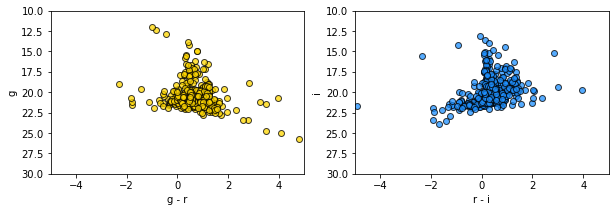

In [20]:
fig, (ax1,ax2) = plt.subplots(1,2)
fig.set_size_inches(10,3)

ax1.scatter(draco_g_r, draco_g_mag, c = "gold", edgecolor = "black", alpha = 0.75)
ax1.set_xlim(-5,5)
ax1.set_ylim(30,10)
ax1.set_xlabel("g - r")
ax1.set_ylabel("g")

ax2.scatter(draco_r_i, draco_i_mag, c = "dodgerblue", edgecolor = "black", alpha = 0.75)
ax2.set_xlim(-5,5)
ax2.set_ylim(30,10)
ax2.set_xlabel("r - i")
ax2.set_ylabel("i")

## Let's overplot the CMDs for Leo I and Draco II 

To compare the compositions of **Leo I** and **Draco II**, we can plot their Color-Magnitude Diagrams on top of each other to see how they differ. As before, we will first plot a CMD in g-r vs g and then in r-i vs i. 

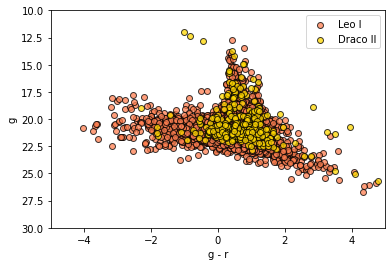

In [21]:
plt.scatter(g_r, g_mag, c = "coral", label = "Leo I", edgecolor = "black", alpha = 0.75)
plt.scatter(draco_g_r, draco_g_mag, c = "gold", label = "Draco II", edgecolor = "black", alpha = 0.75)
plt.xlim(-5,5)
plt.ylim(30,10)
plt.xlabel("g - r")
plt.ylabel("g")
plt.legend()

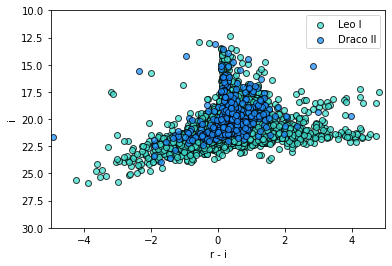

In [22]:
plt.scatter(r_i, i_mag, c = "turquoise", label = "Leo I", edgecolor = "black", alpha = 0.75)
plt.scatter(draco_r_i, draco_i_mag, c = "dodgerblue", label = "Draco II", edgecolor = "black", alpha = 0.75)
plt.xlim(-5,5)
plt.ylim(30,10)
plt.xlabel("r - i")
plt.ylabel("i")
plt.legend()

# Plot Spectral Image for a Member of Leo I
 
We can use the paper [Kirby et al. 2010 ](https://ui.adsabs.harvard.edu/abs/2010ApJS..191..352K/abstract) to find an individual member of **Leo I**. From here we can use the coordinates of a member, search the MAST archive for observations of it, and plot its spectrum.

Let's take a look at member **LeoI72134** by Kirby et al. 2010, we are choosing this star because it has multiple citations so we should be able to learn a lot about it. 

### Convert RA and Dec to Degrees

The coordinates from Kirby et al. 2010 are in units of hour angle while the MAST archive needs units of degrees, so we will have to convert the coordinates.

In [23]:
#Get the RA and Dec
ra = "10 08 01.88"
dec = "+12 17 55.5" 

#Convert the RA and Dec into degrees
c = SkyCoord(ra+dec, unit=(u.hourangle, u.deg))
ra = str(c.ra.deg)
dec = str(c.dec.deg)
print(ra,dec)

152.0078333333333 12.29875


### First, Query MAST Archive for HST observations of LeoI72134

In [24]:
hst_table = Observations.query_criteria(coordinates = ra+dec,radius="0.5 deg", dataproduct_type="spectrum", obs_collection="HST")

#Let's print out some relevant columns of this table
hst_table["instrument_name","filters","target_name","obs_id","calib_level","t_exptime"]

instrument_name,filters,target_name,obs_id,calib_level,t_exptime
str13,str5,str9,str9,int64,float64
STIS/NUV-MAMA,G230L,1007+0042,o8ex88010,3,2400.0
STIS/NUV-MAMA,G230L,1007+0042,o8ex22010,3,2331.0


### Now, we have to select observations for a specific instrument and filter combination

This is made easy by the fact that there is only 1 filter/instrument combination for this object in the HST catalog. That is: G230L, let's look at the observations for that mode. Additionally, we will look at the observation with the longest exposure time, so we will select that observation at this step as well. 

In [25]:
g230L_table = hst_table['obsid','obs_id','target_name','calib_level',
                        't_exptime','filters','em_min','em_max'][hst_table['filters']=='G230L']

sel_table = g230L_table[np.argmin(g230L_table['t_exptime'])]
sel_table

obsid,obs_id,target_name,calib_level,t_exptime,filters,em_min,em_max
str8,str9,str9,int64,float64,str5,float64,float64
24946556,o8ex22010,1007+0042,3,2331.0,G230L,157.0,318.0


### Get the Minimum Recommended Products for this observation

Now, we will query the observations from MAST to get a list of products for our selected observation. Then, we will gather the minimum recommended products needed in order to plot a spectrum. This step is necessary as HST specifically can provide more data than is needed to plot the spectrum of our observation. 

In [26]:
data_products = Observations.get_product_list(sel_table)

wprod = np.where((data_products['productGroupDescription']=='Minimum Recommended Products') & 
                 (data_products['productType']=='SCIENCE'))[0]

data_products[wprod]

obsID,obs_collection,dataproduct_type,obs_id,description,type,dataURI,productType,productGroupDescription,productSubGroupDescription,productDocumentationURL,project,prvversion,proposal_id,productFilename,size,parent_obsid,dataRights,calib_level
str8,str3,str8,str9,str62,str1,str35,str9,str28,str3,str1,str7,str19,str4,str18,int64,str8,str6,int64
24946556,HST,spectrum,o8ex22010,DADS FLT file - Calibrated exposure ACS/WFC3/STIS/COS,D,mast:HST/product/o8ex22010_flt.fits,SCIENCE,Minimum Recommended Products,FLT,--,CALSTIS,3.4.2 (19-Jan-2018),9382,o8ex22010_flt.fits,10535040,24946556,PUBLIC,2


### Download the data to plot

In [27]:
data = Observations.download_products(data_products[wprod])

data

INFO: Found cached file ./mastDownload/HST/o8ex22010/o8ex22010_flt.fits with expected size 10535040. [astroquery.query]


Local Path,Status,Message,URL
str47,str8,object,object
./mastDownload/HST/o8ex22010/o8ex22010_flt.fits,COMPLETE,None,None


### Next, we will investigate the FITS file we just downloaded 

In [28]:
filename = data['Local Path'][0]
hdulist = fits.open(filename)

header = hdulist[0].header
scidata = hdulist[1].data

### Plot the Spectral Image

Now, finally, we can plot the data using Matplotlib. The spectral image of a member of **Leo I** shown here is a 2-dimensional spectral image. The next step could be to extract a spectrum (flux vs wavelength) from this image, and that is left to the user. 

Text(0, 0.5, 'y pixels')

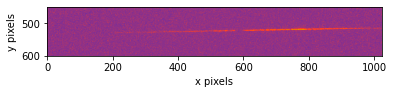

In [29]:
fig = plt.
plt.imshow(scidata, cmap="CMRmap")
plt.ylim(600,450)
plt.xlabel("x pixels")
plt.ylabel("y pixels")

# Exercise

## 1. Plot Field of View of Draco II 

Can you recreate the steps we took for **Leo I** to plot the field of view of **Draco II** in black and white and in color? 


# About this Notebook

**Author:** Emma Lieb <br>
**Last Updated:** Sept 2022

# Citations

* [Citation for `astropy`](https://www.astropy.org/acknowledging.html)